/workspace/traffic-detection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/traffic-detection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


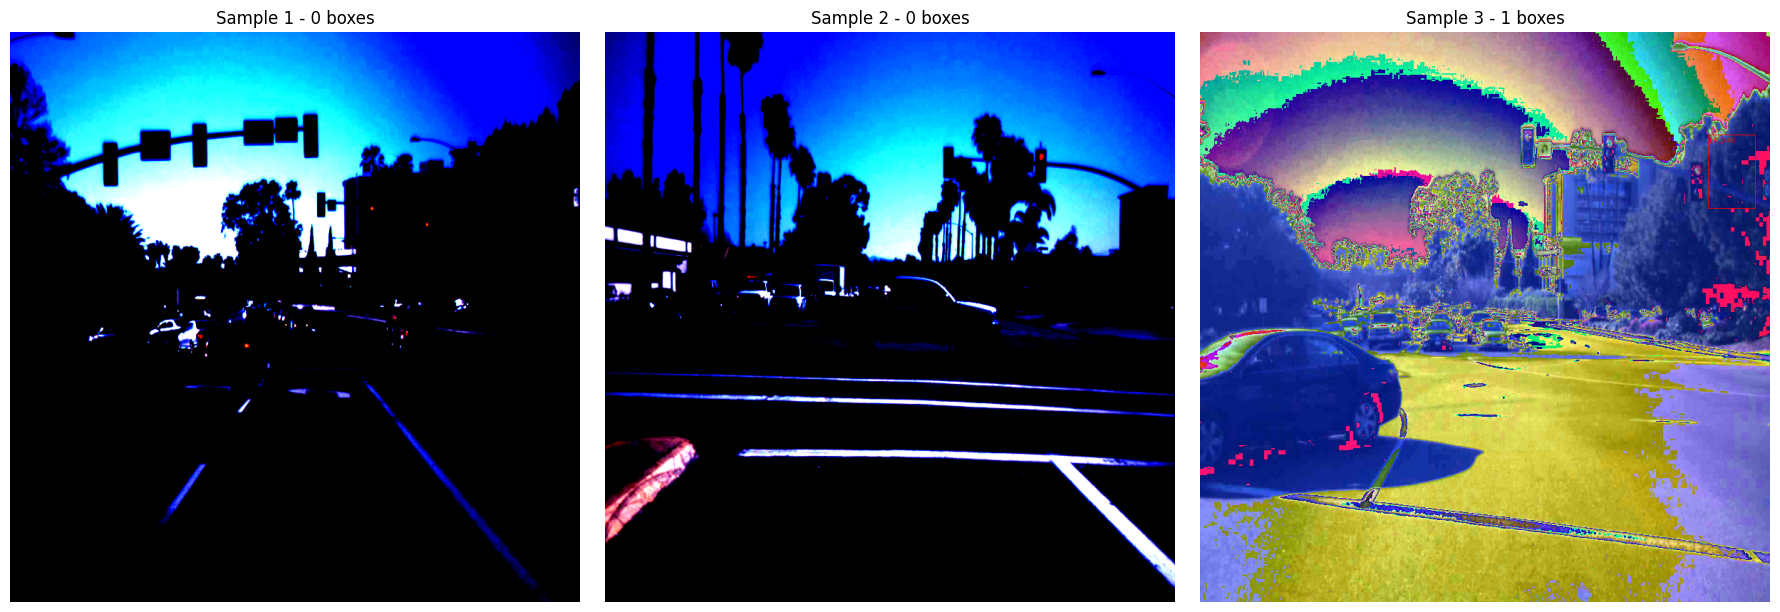

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms.functional import to_pil_image
from traffic_dataset import TrafficDataset
from utils import get_transform, collate_fn
import yaml

# Wczytanie konfiguracji
with open("dataset/dataset_day.yaml", 'r') as f:
    data_cfg = yaml.safe_load(f)

with open("cfg/rcnn_day.yaml", 'r') as f:
    cfg = yaml.safe_load(f)

# Dataset
val_dataset = TrafficDataset(
    csv_file='dataset/annotations_train_balanced_day.csv',
    root_dir=Path("dataset/day/test"),
    transforms=get_transform(train=False, cfg=cfg)
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Model
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, data_cfg['nc'])
model.load_state_dict(torch.load("runs_rcnn/rcnn_day_balanced/weights/epoch10.pth"))
model.eval().cuda()

# Wizualizacja
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, (images, targets) in enumerate(val_loader):
    if i == 3:
        break
    img = images[0].cuda()
    with torch.no_grad():
        pred = model([img])[0]

    keep = pred['scores'] >= 0.3
    boxes = pred['boxes'][keep]
    labels = pred['labels'][keep]
    scores = pred['scores'][keep]

    if boxes.shape[0] > 0:
        labeled_img = draw_bounding_boxes(
            (img.cpu() * 255).byte(),
            boxes=boxes.cpu(),
            labels=[f"{data_cfg['names'][int(l.item())]}: {s:.2f}" for l, s in zip(labels, scores)],
            colors="red"
        )
        axs[i].imshow(to_pil_image(labeled_img))
    else:
        axs[i].imshow(to_pil_image(img.cpu().mul(255).clamp(0, 255).byte()))
    axs[i].axis("off")
    axs[i].set_title(f"Sample {i+1} - {len(boxes)} boxes")

plt.tight_layout()
plt.show()
